In [1]:
import tensorflow as tf
import gym
import os
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
env = gym.make("MsPacman-v0")

In [3]:
obs = env.reset()
obs.shape

(210, 160, 3)

In [4]:
env.action_space

Discrete(9)

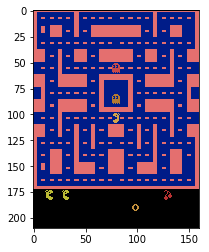

In [6]:
plt.imshow(obs, interpolation='nearest')

A imagem retornada pelo nosso enviroment tem dimensões 210x160 e 3 canais de corees. Vamos reduzi-la para 88x80, deixá-la escala de cinza e aumentar o contraste do nosso Pac-Man para diminuir o número de cálculos necessásrios para nossa DQN

In [64]:
mspacman_color = np.array([210, 164, 74]).mean()

In [65]:
def preprocess_observation(obs):
    img = obs[1:176:2, ::2]
    img = img.mean(axis=2) #to greyscale
    img[img==mspacman_color] = 0
    img = (img - 128)/128 - 1 #normalize from -1 to 1
    return img.reshape(88, 80, 1)

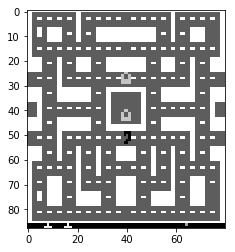

In [66]:
plt.imshow(preprocess_observation(obs).reshape(88, 80), cmap='gray')

Vamos criar uma rede convolucional que receberá o estado atual e retonará o Q-value estimado por action

Serão necessárias duas DQNS com a mesma arquitetura. Uma usada para controlar o Pac Man durante o treinamento (ator) e outra para observá-la e aprender com os erros dela (crítico). Tem tempos em tempos copiaremos a crítica para a atora.

In [67]:
from tensorflow.contrib.layers import convolution2d, fully_connected

In [68]:
#reincia o grafo sempre para o mesmo estado
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)

In [69]:
reset_graph()

In [70]:
input_height = 88
input_width = 80
input_chanels = 1

conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"]*3
conv_activation = [tf.nn.relu]*3
n_hidden_in = 64 * 11 * 10 #conv3 tem 64maps de 11x10 cada, input da hidden
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n #numero de acoes possiveis

initializer = tf.contrib.layers.variance_scaling_initializer()

In [71]:
def q_network(X_state, scope):
    prev_layer = X_state #estado do enviroment
    conv_layers = []
    with tf.variable_scope(scope) as scope:
        for n_maps, kernel_size, stride, padding, activation in zip(
                conv_n_maps, conv_kernel_sizes, conv_strides,
                conv_paddings, conv_activation):
            prev_layer = convolution2d(
                prev_layer, num_outputs=n_maps, kernel_size=kernel_size,
                stride=stride, padding=padding, activation_fn=activation,
                weights_initializer=initializer)
            conv_layers.append(prev_layer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = fully_connected(
            last_conv_layer_flat, n_hidden, activation_fn=hidden_activation,
            weights_initializer=initializer)
        outputs = fully_connected(
            hidden, n_outputs, activation_fn=None,
            weights_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var #removo o nome do scope do nome da variavel
                             for var in trainable_vars}
    return outputs, trainable_vars_by_name

Agora vamos criar um placeholder para copiar uma DQN em outra:

In [72]:
X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width, input_chanels])
actor_q_values, actor_vars = q_network(X_state, scope="q_networks/actor")
critic_q_values, critic_vars = q_network(X_state, scope="q_networks/critic")

In [73]:
copy_ops = [actor_var.assign(critic_vars[var_name])
            for var_name, actor_var in actor_vars.items()]

copy_critic_to_actor = tf.group(*copy_ops)

Para treinar nossa DQN, vamos deixar o ator jogar por um tempo e armazenar sua experiência. Cada memória será composta por 5 elementos (state, acion, next state, reward, continue), onde continue será igual a 0 case o jogo tenha terminado e 1 se não. Em intervalos pre definidos, vamos obter uma amostra desta memória e computar seu Q-Value. Enfim, vamos treinar a DQN crítica para prever esses Q-Values usando a cópia da DQN crítica para a DQN atora.

In [74]:
learning_rate = 0.001
momentum = 0.95

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(actor_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1, keep_dims=True)
    error = tf.abs(y - q_value)
    clipped_error = tf.clip_by_value(error, 0.0, 1.0)
    linear_error = 2 * (error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Nossa função de loss consiste em 2 partes. Usamos uma loss quadritica para valores e pequenos e linear para valores grandes, foi a função quadritica em valores grandes pode gerar muito ruído

Agora precisamos implementar algumas funções auxiliares para a execução e manipulação da memória do nosso agente

In [75]:
import random as rnd
import numpy.random as rnd
from collections import deque

In [76]:
replay_memory_size = 10000
replay_memory = deque([], maxlen=replay_memory_size)

In [77]:
def sample_memories(batch_size):
    indices = rnd.permutation(len(replay_memory))[:batch_size]
    cols = [[], [], [], [], []] #state, action, reward, next_state, continue
    for idx in indices:
        memory = replay_memory[idx]
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return (cols[0], cols[1], cols[2].reshape(-1,1), cols[3],
            cols[4].reshape(-1, 1))

vamos implementar uma política $\epsilon$-gridy para explorar o jogo

In [78]:
eps_min = 0.05
eps_max = 1.0
eps_decay_steps = 50000

In [79]:
def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min)*step/eps_decay_steps)
    if rnd.rand() < epsilon:
        return rnd.randint(n_outputs) #random action
    else:
        return np.argmax(q_values) #optimal action

Agora podemos começar a fase de treinamento

In [80]:
n_steps = 400000 #numero de training steps
training_start = 1000 #comeca a treinar depois de 1000 iteracoes
training_interval = 4 #treina a cada 3 iteracoes do jogo
save_steps = 1000 #salva o modelo a cada 50 steps
copy_steps = 1000 #copia o critico ao ator a cada 1000 steps
discount_rate = 0.99
skip_start = 90 #pula o comeco do jogo, que é o tempo de espera
batch_size = 50

In [81]:
checkpoint_path = "./my_dqn.ckpt"
done = True 

In [47]:
iteration = 0

In [48]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        if step%10000 == 0:
            print('step:', step)
        if done: #game over, recomeca
            obs = env.reset()
            for skip in range(skip_start):
                obs, reward, done, info = env.step(0)
            state = preprocess_observation(obs)
        
        #ator avalia que acao tomar
        q_values = actor_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)
        
        #ator joga
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(obs)
        
        #salva na memoria o que ocorreu
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        
        if iteration < training_start or iteration % training_interval != 0: #pula o treinamento
            continue
            
        #critico aprende com a acao do ator
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (sample_memories(batch_size))
        next_q_values = actor_q_values.eval(feed_dict={X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues*discount_rate*max_next_q_values
        training_op.run(feed_dict={X_state: X_state_val,
                                   X_action: X_action_val,
                                   y: y_val})
        
        #copia critico ao ator
        if step % copy_steps == 0:
            copy_critic_to_actor.run()
        
        #salva
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0
step: 0


/Users/alexmansano/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


step: 10000
step: 10000
step: 10000
step: 10000
step: 20000
step: 20000
step: 20000
step: 20000
step: 30000
step: 30000
step: 30000
step: 30000
step: 40000
step: 40000
step: 40000
step: 40000
step: 50000
step: 50000
step: 50000
step: 50000
step: 60000
step: 60000
step: 60000
step: 60000
step: 70000
step: 70000
step: 70000
step: 70000
step: 80000
step: 80000
step: 80000
step: 80000
step: 90000
step: 90000
step: 90000
step: 90000
step: 100000
step: 100000
step: 100000
step: 100000
step: 110000
step: 110000
step: 110000
step: 110000


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/alexmansano/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-48-d331f2d8105a>", line 20, in <module>
    q_values = actor_q_values.eval(feed_dict={X_state: [state]})
  File "/Users/alexmansano/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 541, in eval
    return _eval_using_default_session(self, feed_dict, self.graph, session)
  File "/Users/alexmansano/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 4085, in _eval_using_default_session
    return session.run(tensors, feed_dict)
  File "/Users/alexmansano/anaconda/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 895, in run
    run_metadata_ptr)
  File "/Users/alexmansano/anaconda/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1127, in _run
    return fetch_

KeyboardInterrupt: 

In [92]:
init = tf.global_variables_initializer()

env = gym.make("MsPacman-v0")

In [93]:
frames = []
n_max_steps = 10000

with tf.Session() as sess:
    saver.restore(sess, './my_dqn.ckpt')
    
    obs = env.reset()
    for step in range(n_max_steps):
        state = preprocess_observation(obs)
        
        q_values = actor_q_values.eval(feed_dict={X_state: [state]})
        action = np.argmax(q_values)
        
        obs, reward, done, info = env.step(action)        
        img = env.render(mode='rgb_array')
        frames.append(img)
        
        if done:
            break

INFO:tensorflow:Restoring parameters from ./my_dqn.ckpt


In [94]:
import matplotlib.animation as animation
%matplotlib nbagg

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), 
                                   frames=len(frames), repeat=repeat, interval=interval)

<IPython.core.display.Javascript object>


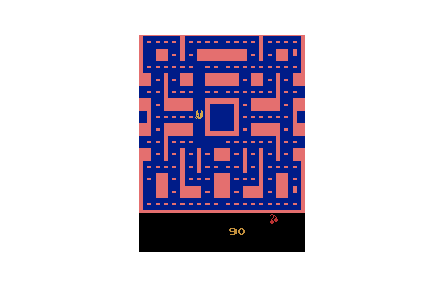

In [95]:
game = plot_animation(frames)